# Test-Feature-Analyse

## Luo Junyu
8/19/2019

Introduction to Computational Literary Analysis
UC-Berkeley, Summer 2019
Instructor: Jonathan Reeve


## I. Introduction 

Authors want their books to be more popular. However, they can hardly predict whether the book will be popular after finishing the book. With the development of the online reading community, there are a lot of people give comment and rating to the book. The rating of the book can partly reflect whether the book is popular. A book is good or not is determined by two things: the content(or the story) and the writing style. At present, it's hard for machines to understand what the story talks about and give a rating score. However, by contrast, the author's writing style is easier to quantify.
In addition to ratings, the type of book can also be classified by analysis of writing styles. Novels and poems should be written in different writing styles. 

In this project, I want to find the relationship between the text of the book and it's rating score and builds a prediction model to predict the rating of the book by analyzing its writing features. And use writing style features to classify different kinds of books.  

## II. Hypothesis
+ The features of a book's writing style affect its rating score.
+ The rating score of a book can be predicted by its writing style features.
+ Books can be classified into different categories by their writing style features.

## III. Body(Code)
### 1. Import   

In [2]:
import nltk
from nltk.corpus import cmudict
from nltk.corpus import stopwords
from nltk.corpus import sentiwordnet as sw
import requests
import collections
import time
import requests
import json
import spacy
import gc
import math
import pandas as pd
import numpy as np
import scipy as sc
import pickle
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
%matplotlib inline

In [25]:
import keras
import tensorflow as tf
from keras.layers import *
from keras.optimizers import Adam

Using TensorFlow backend.


### 2. Related data
+ [*CMU Pronouncing Dictionary*](https://en.wikipedia.org/wiki/CMU_Pronouncing_Dictionary) help to analyze syllables of words.       
+ item_dict: The name for each feature
+ [functional word](https://en.wikipedia.org/wiki/Function_word): words that have little lexical meaning or have ambiguous meaning and express grammatical relationships among other words within a sentence, or specify the attitude or mood of the speaker.

In [3]:
nltk.download('cmudict')
nltk.download('stopwords')
nltk.download("sentiwordnet")

[nltk_data] Downloading package cmudict to D:\nltk_data...
[nltk_data]   Package cmudict is already up-to-date!
[nltk_data] Downloading package stopwords to D:\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package sentiwordnet to D:\nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


True

In [4]:
cmuDictionary = None
global cmuDictionary
cmuDictionary = cmudict.dict()
nlp = spacy.load("en_core_web_lg")

In [5]:
item_dict = {1:"ttr", 2:"word_num", 3:"avgSentLenth_word", 4:"avgSentLenth_char",
             5:"exclamation_ratio", 6:"question_ratio", 7:"quote_ratio", 8:"once_word_ratio",
             9:"avg_word_syllable", 10:"stop_word_ratio", 11:"functional_word_ratio", 12:"flesch_reading_ease",
             13:"flesch_cincade_grade_level", 14:"sentiment_mean", 15:"sentiment_var", 16:"sentiment_ending",
             17:"self.pos[JJ]", 18:"pos[FW]", 19:"pos[RB]", 20:"pos[VB]", 21:"YulesCharacteristic", 22:"shannon_entropy", 23:"dale_chall_readability_formula"}
increase_dict = {-1:"decline", 1:"improve"}

In [6]:
functional_word = """a between in nor some upon
    about both including nothing somebody us
    above but inside of someone used
    after by into off something via
    all can is on such we
    although cos it once than what
    am do its one that whatever
    among down latter onto the when
    an each less opposite their where
    and either like or them whether
    another enough little our these which
    any every lots outside they while
    anybody everybody many over this who
    anyone everyone me own those whoever
    anything everything more past though whom
    are few most per through whose
    around following much plenty till will
    as for must plus to with
    at from my regarding toward within
    be have near same towards without
    because he need several under worth
    before her neither she unless would
    behind him no should unlike yes
    below i nobody since until you
    beside if none so up your
    """
functional_word = functional_word.split()

### 3. Utils

Some functions used in the analysis below.

In [79]:
def lengthOfText(text: str):
    """
    FUNC:    Get the number of the words of the text
    OUTPUT:  The text's lenth (by word)
    """
    tokens = nltk.word_tokenize(text)
    return len(tokens)

In [83]:
def syllable_count(word: str):
    """
    FUNC:    get the syllable count of the word
    INPUT:   a word(string)
    OUTPUT:  syllables number of the words
    """
    global cmuDictionary
    d = cmuDictionary
    count = 0
    try:
        count = [len(list(y for y in x if y[-1].isdigit())) for x in d[word.lower()]][0]
    except:
        word = word.lower()
        count = 0
        vowels = "yaeiou"
        if word[0] in vowels:
            count += 1
        for index in range(1, len(word)):
            if word[index] in vowels and word[index - 1] not in vowels:
                count += 1
        if word.endswith("e"):
            count -= 1
        if count == 0:
            count += 1
    return count

### 4. Book Object
In this part, I build an object `Book` to store each book.

The object is set by `title`, `author name` and `id`. It can download the text and rating, and calculate the features by itself. 

In [7]:
class Book:
    """
    A class to save information of a book
    ...
    Attributes
    ----------
    title: str         --- The title of the book
    author: str        --- The author name of the book
    id_corpus: str     --- The id of the book in corpus-db.org
    id_goodread: str   --- The id of the book in goodreader.com
    text: str          --- The whole text of the book
    rating: float      --- The rating score of the book in goodreader.com
    feature: object    --- The object for the feature of the book
    ...
    Methods
    -------
    set_id_rating      --- Set the id and the rating of the book
    get_feature        --- Output the feature of the book 
    """
    title = ""
    author = ""
    id_corpus = ""                        # id of corpus-db
    id_goodread = ""                      # id of goodreader.com
    text = ""
    rating = 0.0
    feature = None
        
    def __init__(self, title: str, author: str, id_: str):
        """
        FUNC:    Book object initial
        INPUT:   title: the book title
                 author: full name of author
                 id_: id of corpus-db
        """
        self.title = title
        self.author = author
        self.id_corpus = id_
        
    def set_text(self, text: str):
        """
        FUNC:    set the text of the book after download
        INPUT:   text of the novel (string)
        OUTPUT:  lenth of the text (integer)
        """
        self.text = text
        return len(text)
    
    def set_rating(self, rating: str):
        """
        FUNC:    set the rating of the book From goodreaders.com
        INPUT:   rating(string)
        OUTPUT:  rating(float)
        """
        self.rating = float(rating)
        return self.rating
    
    def set_id_rating(self):
        """
        FUNC:    set the id(of goodreads) and rating of given title
        OUTPUT:  True: get the rating successfully
                 False: have wrong in the process of getting the rating 
        """
        url = "https://www.goodreads.com/search/index.xml?q=" + self.title + "&key=" + "u87cBVRCcPR9vIeZTW1M6A"
        response = requests.get(url)
        if response.ok:
            root = ET.fromstring(response.content)
            try:
                id_ = root.find('search').find('results').find('work').find('id')
                print(id_.text)
                rating = root.find('search').find('results').find('work').find('average_rating')
                print(rating.text)
                self.id_goodread = str(id_.text)
                self.rating = float(str(rating.text))
                return True
            except:                               # deal with all fault
                return False
        else:
            print("get rating failed: response failed!")
            return False

    def get_feature(self):
        """
        FUNC:    SET or GET the feature of the book
                 if feature == none then set and init the Feature object
        OUTPUT:  numpy.array of the feature 
                 False: have wrong
        """
        try:
            if not self.feature:   # haven't set yer
                print("====== cal book feature ======")
                self.feature = Feature(self.text)
            return self.feature.get_feature()
        except:                   # deal with all fault
            return False

### 5. Feature Object
This object is set for features in each book.

It can be set by the text, calculate features, and output the features of the book by arrays (`numpy.array`)

We chose 23 features, which can fall into 5 categories: `Vocabulary Feature`, `Vocabulary Richness Feature`, `Sentence Feature`, `Sentiment Feature` and `Readability Feature`.

#### 5.1 Vocabulary Feature
+ Count of the word: $ ( = \frac{Adj\ num}{whole\ words\ num})$ The length of the book may influent readers' rating because readers may don't like too long or too short books.
+ Adjectives Ratio: The Ratio of Adjectives to the whole words. Higher Ratio books may have more descriptions. 
+ Adverbs Ratio: $ ( = \frac{Adv\ num}{whole\ words\ num})$ The Ratio of Adverbs to the whole words. A better book may use fewer adverbs.
+ Foreign Word Ratio: $ ( = \frac{Foreign\ num}{whole\ words\ num})$ The Ratio of Foreign Words to the whole words. 
+ Verb Ratio: $ ( = \frac{Verb\ num}{whole\ words\ num})$ The Ratio of verbs to the whole words. A higher ratio book may have more stories. 
+ Stop Word Ratio: $ ( = \frac{Stop\ word\ num}{whole\ words\ num})$ The Ratio of Stop Word to the whole words. Higher Ratio may show the book is more oral than others.
+ Functional Word Ratio: $ ( = \frac{Functional\ word\ num}{whole\ words\ num})$ The Ratio of Functional words to the whole words. Higher Ratio may also show the book is more oral than others. 
+ Word appear only Once Ratio: $ ( = \frac{Word\ appear\ once\ num}{whole\ words\ num})$
#### 5.2 Vocabulary Richness Feature
+ Type Token Ratio: $( = \frac{Type\ num}{Token\ num})$ show the vocabulary richness of the book.
+ Shannon Entropy: $( H = -\sum_i p_i log_b p_i)$
+ Yules Characteristic 
#### 5.3 Sentence Feature
+ Average Sentence Lenth by word: $( = \frac{Word\ Token\ num}{Sentence\ num})$ The length of the sentence by words, the shorter sentences may indicate that the author is speaking more directly. 
+ Average Sentence Lenth by char：$( = \frac{Text\ Length}{Sentence\ num})$ The length of the sentence by char, the shorter sentences may indicate that the author is speaking more directly.
+ Exclamatory Sentence Ratio： $( = \frac{Exclamatory\ Sentence\ Num}{Sentence\ Num})$ The proportion of exclamatory sentences, a higher ratio means that the author is more emotional, the book may also appear larger emotional ups and downs.
+ Interrogative Sentence Ratio： $( = \frac{Interrogative\ Sentence\ Num}{Sentence\ Num})$ A higher ratio means there are more question in the book. 
+ Quote Sentence Ratio：$( = \frac{Quoted\ Sentence\ Num}{Sentence\ Num})$ A higher ratio means there will be more dialogue in the book.
#### 5.4 Sentiment Feature
+ Sentiment Score Mean (by sentence): The average value of sentiment in the paper indicates that the sentiment in this paper is more positive or negative.
+ Sentiment Score Variance (by sentence)：The variance of the sentiment in the text to show whether there is a big change in the sentiment in the book.
+ Ending Sentiment Score Mean (last 1000 words)：To show if there is a happy ending or a bad ending.
#### 5.5 Readability Feature
Readability is the ease with which a reader can understand a written book.
+ Flesch Reading Ease: $\ \qquad\qquad( = 206.85 - 1.015(\frac{total\ words} {total\ sentences}) - 84.6(\frac{total\ syllables}{total\ words}))$ 
+ Flesch–Kincaid Grade Level: $\qquad( = 0.39(\frac{total\ words}{total\ sentences} + 11.8(\frac{total\ syllables}{total\ wrods}) - 15.59)$ 
+ Dale Chall Readability: $\qquad\qquad( = 0.1579(\frac{diffcult\ words}{total\ words} \times 100) + 0.0496(\frac{total\ words} {total\ sentences}) $ 
+ Average Word Syllable：$\qquad\ \ \ \ \ \ ( = \frac{Syllables\ Sum}{Words\ Num})$

In [88]:
class Feature:
    """
    A class to calculate and save the feature of a book 
    ...
    Attributes
    ----------
    text: str          --- The whole text of the book
    doc                --- nlp(text)
    all_word_tokens    --- the word collection of the text
    all_clean_word_tokens    --- the word collection of the text
    all_sent_tokens    --- the sentence collection of the text
    output: boolean    --- output the debug details
    ----------
    ttr:               --- Type Token Ratio
    word_num:          --- Count of the word
    avgSentLenth_word: --- Average sentence length (by words)
    avgSentLenth_word: --- Average sentence length (by chars)
    exclamation_ratio: --- The Ratio of the exclamation sentence 
    question_ratio:    --- The Ratio of the question sentence
    pos:               --- A dict of all type of pos, the value is ratio of each pos word in text
    quote_ratio:       --- The Ratio of the quoted sentence
    once_word_ratio    --- The ratio of the word which only appeared once
    avg_word_syllable  --- Average of the syllable count per word
    stop_word_ratio    --- The ratio of the stop words of whole words
    functional_word_ratio --- The ratio of the functional words of whole words
    flesch_cincade_grade_level --- Count the flesch cincade grade level
    flesch_reading_ease --- count the flesch_reading_ease
    sentiment_mean     --- average of the sentiment score of whole text
    sentiment_ending   --- average of the sentiment score of the last 1000 words of the text
    sentiment_var      --- the var of the sentiment score
    """
    text = None
    doc = None
    all_word_tokens = None
    all_clean_word_tokens = None
    all_sent_tokens = None
    output = False
    
    ttr = 0.0
    word_num = 0
    avgSentLenth_word = 0
    avgSentLenth_char = 0
    exclamation_ratio = 0.0   
    question_ratio = 0.0
    pos = {"JJ":0,"FW":0,"RB":0,"VB":0}
    quote_ratio = 0.0
    once_word_ratio = 0.0
    avg_word_syllable = 0.0
    stop_word_ratio = 0.0
    functional_word_ratio = 0.0
    flesch_reading_ease = 0.0
    flesch_cincade_grade_level = 0.0
    sentiment_mean = 0.0
    sentiment_ending = 0.0
    sentiment_var = 0.0
    K = None
    shannon_entropy = 0.0
    dale_chall_readability_formula = 0.0
    
    def __init__(self, text: str, output=False):
        self.text = text
        self.doc = nlp(text)
        self.output = output
        self.all_word_tokens = nltk.word_tokenize(text.lower())
        self.all_sent_tokens = nltk.sent_tokenize(text)
        self.all_clean_word_tokens = [word for word in self.all_word_tokens if word.isalpha()]
        #### cal
        self.cal_TypeTokenRatio()
        self.cal_word_num()
        self.cal_AvgSentLenth_word()
        self.cal_AvgSentLenth_char()
        self.cal_exclamation_question_mark_ratio()
        self.cal_POS()
        self.cal_quote_ratio()
        self.cal_once_appear_word_ratio()
        self.cal_avg_word_syllable()
        self.cal_stop_word_ratio()
        self.cal_functional_word_ratio()
        self.cal_flesch_reading_ease()
        self.cal_sentiment()
        self.cal_YulesCharacteristicK()
        self.cal_shannon_entropy()
        self.cal_dale_chall_readability_formula()
        if output:
            print("===== feature cal over =====")
    
    def cal_TypeTokenRatio(self):
        """
        FUNC:    calculate the typetokenration of the whole text
        """
        numTypes = len(set(self.all_word_tokens))
        numTokens = len(self.all_word_tokens)
        ttr = numTypes/numTokens
        self.ttr = ttr
        if self.output:
            print("TypeTokenRatio : " + str(ttr))
    
    def cal_word_num(self):
        self.word_num = len(self.all_word_tokens)
        if self.output:
            print("word_num : " + str(self.word_num))
    
    def cal_AvgSentLenth_word(self):
        """
        FUNC:    calculate the average sentence lenth of the text (by words)
        """
        self.avgSentLenth_word = pd.Series([lengthOfText(sent) for sent in self.all_sent_tokens]).mean()
        if self.output:
            print("avgSentLenth_word : " + str(self.avgSentLenth_word))
    
    def cal_AvgSentLenth_char(self):
        """
        FUNC:    calculate the average sentence lenth of the text (by char)
        """
        self.avgSentLenth_char = pd.Series([len(sent) for sent in self.all_sent_tokens]).mean()
        if self.output:
            print("avgSentLenth_char : " + str(self.avgSentLenth_char))

    def cal_exclamation_question_mark_ratio(self):
        """
        FUNC:    calculate the sentence of exclamation/question mark ratio
        """
        exclamations_num = 0
        question_num = 0
        all_sent_num = 0
        for sent in self.all_sent_tokens:
            all_sent_num += 1
            if sent.strip().endswith('!'):
                exclamations_num += 1
            elif sent.strip().endswith('?'):
                question_num += 1
        self.exclamation_ratio = exclamations_num / all_sent_num
        self.question_ratio = question_num / all_sent_num
        if self.output:
            print("exclamation_ratio: " + str(self.exclamation_ratio))
            print("question_ratio : " + str(self.question_ratio))
    
    def cal_POS(self):
        """
        FUNC:    calculate the ratio of each POS
        """
        all_pos = nltk.pos_tag(self.all_clean_word_tokens)
        for pair in all_pos:
            for pos_tag_ in self.pos.keys():
                if pos_tag_ in pair[1]:
                    self.pos[pos_tag_] += 1
        for pos_tag_ in self.pos.keys():
            self.pos[pos_tag_] /= len(all_pos)
      
    def cal_quote_ratio(self):
        """
        FUNC:    calculate the sentence of quotation mark ratio
        """
        count = 0
        for token in self.all_sent_tokens:
            if '\'' in token or '"' in token or '“' in token or '”'in token:
                count += 1
        self.quote_ratio = count / len(self.all_sent_tokens)
        if self.output:
            print("quote_ratio : " + str(self.quote_ratio))
    
    def cal_once_appear_word_ratio(self):
        """
        FUNC:    calculate the raio of the word appears only once in the text
        """
        num_all_word = len(set(self.all_clean_word_tokens))
        num_once_word = 0
        word_counter = collections.Counter(self.all_clean_word_tokens)
        for word in word_counter.keys():
            if word_counter[word] == 1:
                num_once_word +=1
        self.once_word_ratio = num_once_word / num_all_word
        if self.output:
            print("cal_once_appear_word_ratio : " + str(self.once_word_ratio))
    
    def cal_avg_word_syllable(self):
        """
        FUNC:    calculate the average syllable_num per word
        """
        self.avg_word_syllable = pd.Series([syllable_count(word) for word in self.all_clean_word_tokens]).mean()
        if self.output:
            print("cal_avg_word_syllable : " + str(self.avg_word_syllable))

    def cal_stop_word_ratio(self):
        """
        FUNC:    calculate the stop word ratio of the whole word
        """
        stop_word_count = 0
        all_word_count = 0
        for sent in self.doc.sents:
            for word in sent:
                all_word_count += 1
                if word.is_stop:
                    stop_word_count += 1
        self.stop_word_ratio = stop_word_count / all_word_count
        if self.output:
            print("cal_stop_word_ratio : " + str(self.stop_word_ratio))
    
    def cal_functional_word_ratio(self):
        """
        FUNC:    calculate the functional word ratio of the whole word
        """
        functional_word_count = 0
        for word in self.all_clean_word_tokens:
            if word in functional_word:
                functional_word_count += 1
        self.functional_word_ratio = functional_word_count / len(self.all_clean_word_tokens)
        if self.output:
            print("cal_functional_word_ratio : "+ str(self.functional_word_ratio))

    def cal_flesch_reading_ease(self):
        """
        FUNC:    calculate the flesch_reading_ease of the text
        """
        all_word_num = float(len(self.all_clean_word_tokens))
        all_sent_num = float(len(self.all_sent_tokens))
        all_syllable_num = 0
        for word in self.all_clean_word_tokens:
            all_syllable_num += syllable_count(word)
        rate = 206.835 - 1.015 * (all_word_num / float(all_sent_num)) - 84.6 * (all_syllable_num / all_word_num)
        level = 0.39 * (all_word_num / all_sent_num) + 11.8 * (all_syllable_num / all_word_num) - 15.59
        self.flesch_reading_ease = rate
        self.flesch_cincade_grade_level = level
        if self.output:
            print("cal_flesch_reading_ease : " + str(self.flesch_reading_ease))
            print("cal_flesch_reading_ease : " + str(self.flesch_cincade_grade_level))
            
    def cal_sentiment(self):
        """
        FUNC:    calculate the sentiment_parameter of the text
        """
        lemmaList = []
        sentScores = []
        for sent in self.doc.sents:
            sentLemmaList = []
            for w in sent:
                if (not w.is_stop) and (not w.is_punct) and (w.pos_ is not "PROPN"):
                    sentLemmaList.append((w.lemma_, w.pos_))
            lemmaList.append(sentLemmaList)
        for sent in lemmaList:
            scores = []
            for word, pos in sent:
                synPos = pos.lower()[0]
                if synPos not in ["a","n","y","v"]:
                    continue
                sysnets = list(sw.senti_synsets(word, synPos))
                if type(sysnets) == list and len(sysnets) > 0:
                    sysnet = sysnets[0]
                    score = sysnet.pos_score() - sysnet.neg_score()
                    scores.append(score)
            if len(scores) > 0:
                avgScores = sum(scores) / len(scores)
                sentScores.append(avgScores)
        series = pd.Series(sentScores)
        self.sentiment_mean = series.mean()
        self.sentiment_var = series.var()
        self.sentiment_ending = series.iloc[-1000:].mean()
        if self.output:
            print("sentiment_mean : " + str(self.sentiment_mean))
            print("sentiment_var : " + str(self.sentiment_var))
            print("sentiment_ending : " + str(self.sentiment_ending))
    
    def cal_YulesCharacteristicK(self):
        N = len(self.all_clean_word_tokens)
        freqs = collections.Counter()
        freqs.update(self.all_clean_word_tokens)
        vi = collections.Counter()
        vi.update(freqs.values())
        M = sum([(value * value) * vi[value] for key, value in freqs.items()])
        K = 10000 * (M - N) / math.pow(N, 2)
        self.K = K
    
    def cal_shannon_entropy(self):
        lenght = len(self.all_clean_word_tokens)
        freqs = collections.Counter()
        freqs.update(self.all_clean_word_tokens)
        arr = np.array(list(freqs.values()))
        distribution = 1. * arr
        distribution /= max(1, lenght)
        H = sc.stats.entropy(distribution, base=2)
        self.shannon_entropy = H
    
    def cal_dale_chall_readability_formula(self):
        difficult = 0
        adjusted = 0
        NoOfWords = len(self.all_clean_word_tokens)
        NoOfSectences = len(self.all_sent_tokens)
        with open('dale-chall_unix.pkl', 'rb') as f:
            fimiliarWords = pickle.load(f)
        for word in self.all_clean_word_tokens:
            if word not in fimiliarWords:
                difficult += 1
        percent = (difficult / NoOfWords) * 100
        if (percent > 5):
            adjusted = 3.6365
        D = 0.1579 * (percent) + 0.0496 * (NoOfWords / NoOfSectences) + adjusted
        self.dale_chall_readability_formula = D
    
    def get_feature(self):
        output_array = np.array([self.ttr, self.word_num, self.avgSentLenth_word, self.avgSentLenth_char,
                                 self.exclamation_ratio, self.question_ratio, self.quote_ratio, self.once_word_ratio,
                                 self.avg_word_syllable, self.stop_word_ratio, self.functional_word_ratio, self.flesch_reading_ease,
                                 self.flesch_cincade_grade_level, self.sentiment_mean, self.sentiment_var, self.sentiment_ending,
                                 self.pos["JJ"], self.pos["FW"], self.pos["RB"], self.pos["VB"], self.K, self.shannon_entropy,
                                 self.dale_chall_readability_formula],
                                dtype=np.float32)     
        return output_array

In [9]:
def download_text(id_: str):
    """
    FUNC:    download the text form corpus-db.org
             using id to download it 
             return text(string)
    INPUT:   the id of the book in corpus-db
    OUTPUT:  the text of the book
    """
    text = ""
    response = requests.get('http://corpus-db.org/api/id/'+id_+'/fulltext')
    if response.ok: 
        print("======= get it =======")
        text = response.text
        if len(json.loads(text)) > 0 :
            text = json.loads(text)[0]['text']
        else :
            print("**** response fail ****")
            return False
    else:
        print("**** response fail ****")
        return False
    return text

### 6. Data Download and Calculate

In this part, I build the dataset. 

First of all, I get the list of `Detective and mystery stories`, `science fiction`, `Love stories` and `Poetry`.

Then, I download the text from `corpus-db`, init the object for each book in the list and calculate its literary features. 

**P.S.**: It takes a lot of time to calculate the features, so I save the results in `.csv` files, you can load the parameters by the code below. The `.csv` files are in Github Repo [Text-feature-analysis](https://github.com/Lebway/Text-feature-analysis).

In [10]:
detective_list = json.loads(requests.get("http://corpus-db.org/api/subject/Detective and mystery stories").text)
science_list = json.loads(requests.get("http://corpus-db.org/api/subject/Science fiction").text)
love_list = json.loads(requests.get("http://corpus-db.org/api/subject/Love stories").text)
poetry_list = json.loads(requests.get("http://corpus-db.org/api/subject/Poetry").text)

In [11]:
englist_list = json.loads(requests.get("http://corpus-db.org/api/subject/English fiction -- 19th century").text)
america_list = json.loads(requests.get("http://corpus-db.org/api/subject/American%20fiction%20--%2019th%20century").text)

In [12]:
def download_cal_list(book_list, name):
        count = 0
        df = pd.DataFrame()
        for i in book_list:
            print("==============================================")
            count += 1 
            try:
                print(count)
                title = i["title"]
                if ':' in title:
                    title = title.split(':')[0]
                elif ',' in title:
                    title = title.split(',')[0]
                elif '—' in title:
                    title = title.split('—')[0]
                elif '.' in title:
                    title = title.split('.')[0]

                id_ = i["id"]
                author = i["creator"]
                if "agent_name" in author:
                    author = author.split('\'')[5]
                else:
                    author = None
                newbook = Book(title=title, id_=id_, author=author)
                print(title)
                text = download_text(id_)
                if not text:
                    continue
                length = newbook.set_text(text)        
                if not newbook.set_id_rating():
                    continue
                rating = newbook.rating
                if rating == 0.0:                              # clear the book get no rating
                    continue
                feature_array = newbook.get_feature()
                if feature_array is False:
                    continue
                series = pd.Series(feature_array, name=title)
                series["rating"] = rating
                df = df.append(series)
                del newbook
                gc.collect()
                if count % 50 == 1:
                    df.to_csv("save_"+ name +str(count)+".csv")
            except:                                            # in case of it stops halfway
                df.to_csv("save_"+ name +str(count)+".csv")
                continue
        df.to_csv("save_" + name + "final" + ".csv")

In [105]:
download_cal_list(englist_list, "englisth")
download_cal_list(america_list,"america")

1
The Gathering of Brother Hilarius
======= get it =======
**** response fail ****
2
The Perils of Certain English Prisoners
======= get it =======
6246178
3.26
====== cal book feature ======
3
A Message from the Sea
======= get it =======
2501679
3.27
====== cal book feature ======
4
The Private Papers of Henry Ryecroft
======= get it =======
1789543
3.91
====== cal book feature ======
5
The History of Samuel Titmarsh
======= get it =======
6626488
3.33
====== cal book feature ======
6
A Simpleton
======= get it =======
54316315
3.95
====== cal book feature ======
7
A House to Let
======= get it =======
1955711
3.60
====== cal book feature ======
8
Stories By English Authors
======= get it =======
4995469
3.16
====== cal book feature ======
9
The Lady of Lyons; Or
======= get it =======
3004167
4.00
====== cal book feature ======
10
Put Yourself in His Place
======= get it =======
6696269
4.57
====== cal book feature ======
11
Heartsease; Or
======= get it =======
2297591
3.83
====== 

====== cal book feature ======
121
The Caxtons
======= get it =======
255481
3.62
====== cal book feature ======
122
The Caxtons
======= get it =======
255481
3.62
====== cal book feature ======
123
The Caxtons
======= get it =======
255481
3.62
====== cal book feature ======
124
The Caxtons
======= get it =======
255481
3.62
====== cal book feature ======
125
The Caxtons
======= get it =======
255481
3.62
====== cal book feature ======
126
Pelham 
======= get it =======
1688058
3.77
====== cal book feature ======
127
Pelham 
======= get it =======
1688058
3.77
====== cal book feature ======
128
Pelham 
======= get it =======
1688058
3.77
====== cal book feature ======
129
Pelham 
======= get it =======
1688058
3.77
====== cal book feature ======
130
Pelham 
======= get it =======
1688058
3.77
====== cal book feature ======
131
Pelham 
======= get it =======
1688058
3.77
====== cal book feature ======
132
Pelham 
======= get it =======
1688058
3.77
====== cal book feature ======
133
Pe

Some Persons Unknown
======= get it =======
42498770
0.0
245
The Notting Hill Mystery
======= get it =======
**** response fail ****
1
The Autocrat of the Breakfast-Table
======= get it =======
769797
3.41
====== cal book feature ======
2
The Works of Edgar Allan Poe 
======= get it =======
45971917
4.50
====== cal book feature ======
3
The Works of Edgar Allan Poe 
======= get it =======
45971917
4.50
====== cal book feature ======
4
The Works of Edgar Allan Poe 
======= get it =======
45971917
4.50
====== cal book feature ======
5
The Works of Edgar Allan Poe 
======= get it =======
45971917
4.50
====== cal book feature ======
6
The Works of Edgar Allan Poe 
======= get it =======
45971917
4.50
====== cal book feature ======
7
Thankful Blossom
======= get it =======
6287330
3.67
====== cal book feature ======
8
By Shore and Sedge
======= get it =======
13045024
3.40
====== cal book feature ======
9
Drift from Two Shores
======= get it =======
11048256
4.00
====== cal book feature ===

In [78]:
download_cal_list(science_list, "science")

1
The Time Machine
======= get it =======
3234863
3.88
====== cal book feature ======
2
The War of the Worlds
======= get it =======
3194841
3.81
====== cal book feature ======
3
The Strange Case of Dr
======= get it =======
3164921
3.80
====== cal book feature ======
4
The Strange Case of Dr
======= get it =======
3164921
3.80
====== cal book feature ======
5
A Princess of Mars
======= get it =======
1129624
3.80
====== cal book feature ======
6
The Gods of Mars
======= get it =======
2816507
3.87
====== cal book feature ======
7
Warlord of Mars
======= get it =======
2816562
3.86
====== cal book feature ======
8
Thuvia
======= get it =======
1387380
3.75
====== cal book feature ======
9
From the Earth to the Moon; and
======= get it =======
14165539
3.78
====== cal book feature ======
10
Frankenstein; Or
======= get it =======
4836639
3.78
====== cal book feature ======
11
The Monster Men
======= get it =======
7160343
4.25
====== cal book feature ======
12
At the Earth's Core
======

3.89
====== cal book feature ======
119
The Sleeper Awakes
======= get it =======
25422057
3.80
====== cal book feature ======
120
The Flying Legion
======= get it =======
5328678
3.44
====== cal book feature ======
121
Sans dessus dessous
======= get it =======
**** response fail ****
122
The Stolen Bacillus and Other Incidents
======= get it =======
1112610
3.64
====== cal book feature ======
123
The Air Trust
======= get it =======
3736427
2.73
====== cal book feature ======
124
The Moon-Voyage
======= get it =======
26884062
3.63
====== cal book feature ======
125
R
======= get it =======
6277
4.09
====== cal book feature ======
126
The Certainty of a Future Life in Mars
======= get it =======
27509573
4.00
====== cal book feature ======
127
Zarlah the Martian
======= get it =======
2975906
2.75
====== cal book feature ======
128
In the Clutch of the War-God
======= get it =======
13125197
2.60
====== cal book feature ======
129
Scorched Earth
======= get it =======
520775
3.97
===

====== cal book feature ======
239
Highways in Hiding
======= get it =======
2512106
3.67
====== cal book feature ======
240
The White Invaders
======= get it =======
6398429
3.00
====== cal book feature ======
241
Out Around Rigel
======= get it =======
16251479
3.23
====== cal book feature ======
242
Oomphel in the Sky
======= get it =======
2968542
3.66
====== cal book feature ======
243
Ministry of Disturbance
======= get it =======
13478691
3.78
====== cal book feature ======
244
The Black Star Passes
======= get it =======
2030151
3.27
====== cal book feature ======
245
The Man With The Broken Ear
======= get it =======
3208802
3.39
====== cal book feature ======
246
A Slave is a Slave
======= get it =======
40767237
4.21
====== cal book feature ======
247
The Cosmic Computer
======= get it =======
1658187
3.73
====== cal book feature ======
248
Space Viking
======= get it =======
3097582
3.76
====== cal book feature ======
249
Rebels of the Red Planet
======= get it =======
3397

359
Stairway to the Stars
======= get it =======
21390950
3.91
====== cal book feature ======
360
Solomon's Orbit
======= get it =======
15069948
3.38
====== cal book feature ======
361
No Great Magic
======= get it =======
6464146
3.54
====== cal book feature ======
362
The Creature from Cleveland Depths
======= get it =======
7270914
3.66
====== cal book feature ======
363
The Glory of Ippling
======= get it =======
25536105
2.50
====== cal book feature ======
364
The Common Man
======= get it =======
10196002
4.15
====== cal book feature ======
365
Subversive
======= get it =======
7313789
3.38
====== cal book feature ======
366
With No Strings Attached
======= get it =======
13585192
3.57
====== cal book feature ======
367
Missing Link
======= get it =======
26582910
4.19
====== cal book feature ======
368
The Servant Problem
======= get it =======
19021591
3.10
====== cal book feature ======
369
Unwise Child
======= get it =======
958482
2.97
====== cal book feature ======
370
Tig

====== cal book feature ======
481
The Monster
======= get it =======
13492114
4.37
====== cal book feature ======
482
Aventures extraordinaires d'un savant russe
======= get it =======
17865253
0.0
====== cal book feature ======
483
A Matter of Magnitude
======= get it =======
6521084
3.62
====== cal book feature ======
484
Longevity
======= get it =======
67674893
3.67
====== cal book feature ======
485
Control Group
======= get it =======
14245013
3.12
====== cal book feature ======
486
Man Made
======= get it =======
19112578
3.71
====== cal book feature ======
487
Second Landing
======= get it =======
644171
4.17
====== cal book feature ======
488
Aventures extraordinaires d'un savant russe
======= get it =======
17865253
0.0
====== cal book feature ======
489
The Deadly Daughters
======= get it =======
43447034
3.48
====== cal book feature ======
490
Survival Tactics
======= get it =======
6609092
3.51
====== cal book feature ======
491
The Gift Bearer
======= get it =======
1872

601
The Doomsman
======= get it =======
2067106
3.33
====== cal book feature ======
602
Revenge
======= get it =======
2651193
3.87
====== cal book feature ======
603
Vital Ingredient
======= get it =======
15572964
3.30
====== cal book feature ======
604
The Love of Frank Nineteen
======= get it =======
18737194
3.50
====== cal book feature ======
605
Tulan
======= get it =======
21838910
3.67
====== cal book feature ======
606
Reluctant Genius
======= get it =======
17192691
3.03
====== cal book feature ======
607
Resurrection
======= get it =======
1491227
4.12
====== cal book feature ======
608
Walls of Acid
======= get it =======
6541744
3.33
====== cal book feature ======
609
Shepherd of the Planets
======= get it =======
6558468
2.67
====== cal book feature ======
610
The Man Who Saw the Future
======= get it =======
6498983
3.21
====== cal book feature ======
611
The Next Logical Step
======= get it =======
6455079
3.59
====== cal book feature ======
612
Moment of Truth
=======

720
Pariah Planet
======= get it =======
48835664
3.94
====== cal book feature ======
721
Invasion
======= get it =======
42216232
4.12
====== cal book feature ======
722
Loot of the Void
======= get it =======
46169636
2.00
====== cal book feature ======
723
Cost of Living
======= get it =======
3138069
4.18
====== cal book feature ======
724
Lords of the Stratosphere
======= get it =======
11135816
3.50
====== cal book feature ======
725
The Velvet Glove
======= get it =======
372591
4.07
====== cal book feature ======
726
Under Arctic Ice
======= get it =======
6867438
3.40
====== cal book feature ======
727
Forever
======= get it =======
423
4.15
====== cal book feature ======
728
We're Friends
======= get it =======
2113960
4.11
====== cal book feature ======
729
Old Rambling House
======= get it =======
16508819
3.30
====== cal book feature ======
730
The Hated
======= get it =======
45762345
4.19
====== cal book feature ======
731
What's He Doing in There?
======= get it =======

840
Status Quo
======= get it =======
55379993
4.50
====== cal book feature ======
841
The Last Supper
======= get it =======
55973541
3.75
====== cal book feature ======
842
The Smiler
======= get it =======
6582125
4.23
====== cal book feature ======
843
The Stowaway
======= get it =======
452722
3.48
====== cal book feature ======
844
Service with a Smile
======= get it =======
435420
4.16
====== cal book feature ======
845
Field Trip
======= get it =======
43311654
3.64
====== cal book feature ======
846
Pipe of Peace
======= get it =======
18101145
3.12
====== cal book feature ======
847
Prelude to Space
======= get it =======
2116994
3.63
====== cal book feature ======
848
Say "Hello" for Me
======= get it =======
18586179
3.11
====== cal book feature ======
849
Spies Die Hard!
======= get it =======
37378669
2.88
====== cal book feature ======
850
The One and the Many
======= get it =======
3217787
4.06
====== cal book feature ======
851
The Other Likeness
======= get it =======

====== cal book feature ======
961
Out of the Earth
======= get it =======
228833
4.14
====== cal book feature ======
962
To Remember Charlie By
======= get it =======
645228
3.81
====== cal book feature ======
963
An Empty Bottle
======= get it =======
63258952
3.76
====== cal book feature ======
964
Robots of the World! Arise!
======= get it =======
20107711
3.85
====== cal book feature ======
965
The Very Secret Agent
======= get it =======
27318675
2.00
====== cal book feature ======
966
The Planet Savers
======= get it =======
1073262
3.76
====== cal book feature ======
967
The Vilbar Party
======= get it =======
14857888
3.30
====== cal book feature ======
968
Helpfully Yours
======= get it =======
37343533
3.25
====== cal book feature ======
969
My Fair Planet
======= get it =======
37341372
3.62
====== cal book feature ======
970
The Instant of Now
======= get it =======
14886606
5.00
====== cal book feature ======
971
Conquest Over Time
======= get it =======
12931946
3.55
===

====== cal book feature ======
1081
The Animated Pinup
======= get it =======
13402721
3.33
====== cal book feature ======
1082
Keep Your Shape
======= get it =======
40156604
3.74
====== cal book feature ======
1083
Time Fuze
======= get it =======
13451842
3.47
====== cal book feature ======
1084
Voyage To Eternity
======= get it =======
41911701
3.67
====== cal book feature ======
1085
The Mind Digger
======= get it =======
13454145
3.00
====== cal book feature ======
1086
Sinister Paradise
======= get it =======
14872654
2.00
====== cal book feature ======
1087
The Holes Around Mars
======= get it =======
15251872
3.52
====== cal book feature ======
1088
The Prophetic Camera
======= get it =======
56783825
4.00
====== cal book feature ======
1089
Black Man's Burden
======= get it =======
15372197
3.49
====== cal book feature ======
1090
Oogie Finds Love
======= get it =======
15149132
3.50
====== cal book feature ======
1091
Brood of the Dark Moon
======= get it =======
14609326
3.

1201
A Woman's Place
======= get it =======
77584
4.16
====== cal book feature ======
1202
When the Mountain Shook
======= get it =======
15794268
3.21
====== cal book feature ======
1203
Check and Checkmate
======= get it =======
17563985
3.58
====== cal book feature ======
1204
The Tree of Life
======= get it =======
13774596
3.20
====== cal book feature ======
1205
In the Cards
======= get it =======
18230950
3.95
====== cal book feature ======
1206
Perchance to Dream
======= get it =======
44222791
3.91
====== cal book feature ======
1207
The Genius
======= get it =======
42857
3.68
====== cal book feature ======
1208
Bedside Manner
======= get it =======
7004934
3.67
====== cal book feature ======
1209
Beyond The Thunder
======= get it =======
15667193
5.00
====== cal book feature ======
1210
Castle of Terror
======= get it =======
6729163
3.93
====== cal book feature ======
1211
Thy Rocks and Rills
======= get it =======
47067548
4.50
====== cal book feature ======
1212
Circle of

1261
The Scapegoat
======= get it =======
2278127
3.96
====== cal book feature ======
1262
The Men Who Wrought
======= get it =======
6888355
3.00
====== cal book feature ======
1263
Progress Report
======= get it =======
34376250
3.33
====== cal book feature ======
1264
Het voedsel der Goden en hoe het op Aarde kwam
======= get it =======
1265
Het toekomend jaar drie duizend
======= get it =======
22007083
4.00
====== cal book feature ======
1266
The Image and the Likeness
======= get it =======
695734
4.19
====== cal book feature ======
1267
The City in the Clouds
======= get it =======
360443
3.87
====== cal book feature ======
1268
Comet's Burial
======= get it =======
54733131
0.0
====== cal book feature ======
1269
Kort verhaal van eene aanmerkelijke luchtreis en nieuwe planeetontdekking
======= get it =======
16849590
3.09
====== cal book feature ======
1270
The Way of Decision
======= get it =======
17092259
2.00
====== cal book feature ======
1271
Sentiment
======= get it ====

In [80]:
download_cal_list(love_list,"love")

1
Far from the Madding Crowd
======= get it =======
914540
3.94
====== cal book feature ======
2
Ivanhoe
======= get it =======
1039021
3.75
====== cal book feature ======
3
Persuasion
======= get it =======
2534720
4.13
====== cal book feature ======
4
Far from the Madding Crowd
======= get it =======
914540
3.94
====== cal book feature ======
5
Violists
======= get it =======
1677829
4.11
====== cal book feature ======
6
Northanger Abbey
======= get it =======
4039699
3.81
====== cal book feature ======
7
The Return of the Native
======= get it =======
3140534
3.85
====== cal book feature ======
8
Mansfield Park
======= get it =======
2722329
3.85
====== cal book feature ======
9
The Voyage Out
======= get it =======
1412170
3.76
====== cal book feature ======
10
Middlemarch
======= get it =======
1461747
3.95
====== cal book feature ======
11
Jude the Obscure
======= get it =======
41342119
3.82
====== cal book feature ======
12
Daddy-Long-Legs
======= get it =======
1710545
4.12
==

49638190
4.53
====== cal book feature ======
123
Darkness and Daylight
======= get it =======
1522525
3.43
====== cal book feature ======
124
The Lilac Sunbonnet
======= get it =======
9273809
3.33
====== cal book feature ======
125
Our Mr. Wrenn
======= get it =======
3773895
3.40
====== cal book feature ======
126
The Belton Estate
======= get it =======
2826186
3.82
====== cal book feature ======
127
The Unspeakable Perk
======= get it =======
1243971
3.67
====== cal book feature ======
128
The Lion and the Mouse; a Story of an American Life
======= get it =======
6726263
4.24
====== cal book feature ======
129
The Trail of the Lonesome Pine
======= get it =======
2953130
3.81
====== cal book feature ======
130
Graustark
======= get it =======
531857
3.81
====== cal book feature ======
131
Innocent 
======= get it =======
14597050
3.96
====== cal book feature ======
132
Sant' Ilario
======= get it =======
972094
3.67
====== cal book feature ======
133
The Point of View
======= get i

Mischievous Maid Faynie
======= get it =======
15314502
2.80
====== cal book feature ======
244
The Lamp in the Desert
======= get it =======
6564547
3.51
====== cal book feature ======
245
Charles Rex
======= get it =======
4196483
3.81
====== cal book feature ======
246
Nedra
======= get it =======
4509999
3.58
====== cal book feature ======
247
Through stained glass
======= get it =======
19967481
2.00
====== cal book feature ======
248
The End of the World
======= get it =======
2531870
4.15
====== cal book feature ======
249
Max
======= get it =======
3787812
4.07
====== cal book feature ======
250
Westways
======= get it =======
6876180
4.00
====== cal book feature ======
251
The Lion and The Mouse
======= get it =======
6726263
4.24
====== cal book feature ======
252
Wanted
======= get it =======
58025501
3.88
====== cal book feature ======
253
The Helmet of Navarre
======= get it =======
3596850
3.36
====== cal book feature ======
254
Half A Chance
======= get it =======
256561

362
A Philanthropist
======= get it =======
906396
3.98
====== cal book feature ======
363
Julia The Apostate
======= get it =======
6612865
0.0
====== cal book feature ======
364
The Courting Of Lady Jane
======= get it =======
15141954
4.00
====== cal book feature ======
365
Mrs
======= get it =======
841320
3.79
====== cal book feature ======
366
Die Kurtisane Jamaica
======= get it =======
20052200
0.0
====== cal book feature ======
367
Chance
======= get it =======
21424080
3.86
====== cal book feature ======
368
The Little Gray Lady
======= get it =======
40455240
2.80
====== cal book feature ======
369
The Lost Girl
======= get it =======
61573651
3.89
====== cal book feature ======
370
At Fault
======= get it =======
16827462
4.23
====== cal book feature ======
371
Old Valentines
======= get it =======
23626559
2.91
====== cal book feature ======
372
夢中緣
======= get it =======
**** response fail ****
373
Miss Mackenzie
======= get it =======
434407
3.94
====== cal book feature 

======= get it =======
1039021
3.75
====== cal book feature ======
482
Ivanhoe (3/4)
======= get it =======
1039021
3.75
====== cal book feature ======
483
The Enchanted Barn
======= get it =======
561130
4.30
====== cal book feature ======
484
Cursed by a Fortune
======= get it =======
17320773
0.0
====== cal book feature ======
485
Ivanhoe (4/4)
======= get it =======
1039021
3.75
====== cal book feature ======
486
The Gateless Barrier
======= get it =======
19798856
3.10
====== cal book feature ======
487
I, Thou, and the Other One
======= get it =======
17666566
3.33
====== cal book feature ======
488
Petticoat Rule
======= get it =======
71919283
0.0
====== cal book feature ======
489
The Boss of Wind River
======= get it =======
23588850
3.83
====== cal book feature ======
490
A Lame Dog's Diary
======= get it =======
27298482
3.83
====== cal book feature ======
491
She Buildeth Her House
======= get it =======
15133456
4.00
====== cal book feature ======
492
The Pursuit
======= 

602
Amazing Grace
======= get it =======
1831295
4.34
====== cal book feature ======
603
The Boss of Taroomba
======= get it =======
24703843
0.0
====== cal book feature ======
604
Phroso
======= get it =======
1228830
4.14
====== cal book feature ======
605
Wild Heather
======= get it =======
1734266
3.82
====== cal book feature ======
606
Polly the Pagan
======= get it =======
65670110
0.0
====== cal book feature ======
607
The Barrier
======= get it =======
2989134
4.08
====== cal book feature ======
608
A Bachelor Husband
======= get it =======
2863603
3.62
====== cal book feature ======
609
The Pirate
======= get it =======
46636002
3.99
====== cal book feature ======
610
Vadertje Langbeen
======= get it =======
1710545
4.12
====== cal book feature ======
611
Mason of Bar X Ranch
======= get it =======
25947286
4.00
====== cal book feature ======
612
The Lonely Stronghold
======= get it =======
20237598
3.33
====== cal book feature ======
613
Pride and Prejudice
======= get it ===

In [82]:
download_cal_list(poetry_list, "poetry")

1
The Song of Hiawatha
======= get it =======
2783902
3.90
====== cal book feature ======
2
Paradise Lost
======= get it =======
1031493
3.81
====== cal book feature ======
3
Paradise Lost
======= get it =======
1031493
3.81
====== cal book feature ======
4
Paradise Regained
======= get it =======
17792
3.65
====== cal book feature ======
5
The Rime of the Ancient Mariner
======= get it =======
678243
3.94
====== cal book feature ======
6
The Spell of the Yukon and Other Verses
======= get it =======
109005
4.30
====== cal book feature ======
7
The Man from Snowy River
======= get it =======
1841293
4.00
====== cal book feature ======
8
In the Days When the World Was Wide
======= get it =======
14605865
3.00
====== cal book feature ======
9
Aeneidos
======= get it =======
288738
3.83
====== cal book feature ======
10
The Aeneid
======= get it =======
288738
3.83
====== cal book feature ======
11
The Bucolics and Eclogues
======= get it =======
13142034
3.00
====== cal book feature ====

123
Rouge mémoire
======= get it =======
25044023
0.0
====== cal book feature ======
124
Jusqu'à l'extrême regard
======= get it =======
125
Entre la chair et l'âme
======= get it =======
3069880
0.0
====== cal book feature ======
126
Strates Amoureuses
======= get it =======
127
Les Visages Du Temps
======= get it =======
27886259
4.50
====== cal book feature ======
128
Mots Rouge Espoir
======= get it =======
129
Ascension Du Désir
======= get it =======
**** response fail ****
130
The Daemon of the World
======= get it =======
14509751
3.96
====== cal book feature ======
131
Town and Country; Or
======= get it =======
190541
4.11
====== cal book feature ======
132
The Witch of Atlas
======= get it =======
14472370
3.51
====== cal book feature ======
133
Peter Bell the Third
======= get it =======
13697768
3.44
====== cal book feature ======
134
Les Chansons De Bilitis
======= get it =======
61483000
2.67
====== cal book feature ======
135
Dans Le Fondu Des Mots
======= get it ======

====== cal book feature ======
243
Anti-Slavery Poems 2.
======= get it =======
17049328
4.50
====== cal book feature ======
244
Anti-Slavery Poems 3.
======= get it =======
17049329
4.00
====== cal book feature ======
245
Poems in Wartime
======= get it =======
49736361
0.0
====== cal book feature ======
246
Songs of Labor and Reform
======= get it =======
49736369
0.0
====== cal book feature ======
247
Anti-Slavery Poems and Songs of Labor and Reform, Complete
======= get it =======
49650450
0.0
====== cal book feature ======
248
A Little Book of Western Verse
======= get it =======
26518110
3.29
====== cal book feature ======
249
The Botanic Garden
======= get it =======
14618836
4.47
====== cal book feature ======
250
Poesie e novelle in versi
======= get it =======
40736516
0.0
====== cal book feature ======
251
Horace
======= get it =======
823702
3.56
====== cal book feature ======
252
A Wreath of Virginia Bay Leaves
======= get it =======
26863645
4.00
====== cal book feature =

360
Mountain Idylls
======= get it =======
814419
3.67
====== cal book feature ======
361
The Wreck of the Hesperus
======= get it =======
2136793
4.20
====== cal book feature ======
362
Rhymes of the Rookies
======= get it =======
19967484
0.0
====== cal book feature ======
363
Pipes O'Pan at Zekesbury
======= get it =======
16321383
3.20
====== cal book feature ======
364
The Last West and Paolo's Virginia
======= get it =======
46191459
3.50
====== cal book feature ======
365
The Horse Shoe
======= get it =======
27319068
2.71
====== cal book feature ======
366
The Ladies Delight
======= get it =======
12948491
2.93
====== cal book feature ======
367
Eighteen Hundred and Eleven
======= get it =======
261272
3.18
====== cal book feature ======
368
Grashalmen
======= get it =======
28117
4.12
====== cal book feature ======
369
Landscape and Song
======= get it =======
55693219
4.46
====== cal book feature ======
370
Books and Habits
======= get it =======
12988021
4.20
====== cal book

====== cal book feature ======
477
Letters Concerning Poetical Translations
======= get it =======
52447469
1.00
====== cal book feature ======
478
The Arctic Queen
======= get it =======
10078539
3.00
====== cal book feature ======
479
My Beautiful Lady
======= get it =======
1794308
1.00
====== cal book feature ======
480
Amusing Trial in which a Yankee Lawyer Renders a Just Verdict
======= get it =======
6512129
4.12
====== cal book feature ======
481
Livro de Máguas
======= get it =======
60936749
4.50
====== cal book feature ======
482
A Jongleur Strayed
======= get it =======
65967989
0.0
====== cal book feature ======
483
Christmas Tales and Christmas Verse
======= get it =======
185572
3.28
====== cal book feature ======
484
De muis, of De gestoorde nachtrust
======= get it =======
15373782
3.00
====== cal book feature ======
485
Poesie scelte
======= get it =======
14604191
4.17
====== cal book feature ======
486
Il libro delle figurazioni ideali
======= get it =======
4034050

534
Ang mga Anak Dalita
======= get it =======
15128813
5.00
====== cal book feature ======
535
Christmas
======= get it =======
3097440
4.04
====== cal book feature ======
536
The Rose of Dawn
======= get it =======
1433876
3.64
====== cal book feature ======
537
In the Yule-Log Glow, Book II
======= get it =======
27153300
0.0
====== cal book feature ======
538
Indian Legends and Other Poems
======= get it =======
1948493
4.00
====== cal book feature ======
539
Primavera
======= get it =======
1513
3.92
====== cal book feature ======
540
The Dog's Book of Verse
======= get it =======
46771685
3.00
====== cal book feature ======
541
Bohemian Days
======= get it =======
13317778
2.00
====== cal book feature ======
542
The Poems of Giacomo Leopardi
======= get it =======
61830222
0.0
====== cal book feature ======
543
War Rhymes by Wayfarer
======= get it =======
41785161
0.0
====== cal book feature ======
544
The Modern Scottish Minstrel, Volume 3.
======= get it =======
14410517
0.0
=

====== cal book feature ======
651
The Example of Vertu
======= get it =======
41619420
1.00
====== cal book feature ======
652
The Hesperides & Noble Numbers
======= get it =======
46061168
4.07
====== cal book feature ======
653
Poems
======= get it =======
30431
4.38
====== cal book feature ======
654
The Aeneid of Virgil
======= get it =======
288738
3.83
====== cal book feature ======
655
Cintra
======= get it =======
60460
4.10
====== cal book feature ======
656
A morte do athleta
======= get it =======
65939754
0.0
====== cal book feature ======
657
Fringilla
======= get it =======
72300834
0.0
====== cal book feature ======
658
An Heroic Epistle to the Right Honourable the Lord Craven (3rd Ed
======= get it =======
40568689
4.00
====== cal book feature ======
659
The Modern Scottish Minstrel, Volumes 1-6.
======= get it =======
26402998
4.00
====== cal book feature ======
660
The Twelve Labours of Hercules
======= get it =======
50552683
3.22
====== cal book feature ======
661


**** response fail ****
769
Punicorum Libri Septemdecim
======= get it =======
55584883
0.0
====== cal book feature ======
770
The Minstrel; or the Progress of Genius
======= get it =======
45637429
3.68
====== cal book feature ======
771
Os Lusíadas
======= get it =======
**** response fail ****
772
O Marquez de Pombal á luz da Philosophia
======= get it =======
41710489
0.0
====== cal book feature ======
773
The Angel of Thought and Other Poems
======= get it =======
47948127
0.0
====== cal book feature ======
774
Nothing to Say
======= get it =======
1679416
3.71
====== cal book feature ======
775
Les poésies de Sapho de Lesbos
======= get it =======
1456006
4.16
====== cal book feature ======
776
Pan and Æolus
======= get it =======
41354132
0.0
====== cal book feature ======
777
Africa Orrenda
======= get it =======
26956949
0.0
====== cal book feature ======
778
Three Women
======= get it =======
65558120
3.94
====== cal book feature ======
779
Poems
======= get it =======
30431


====== cal book feature ======
887
Collected Poems
======= get it =======
1003095
4.20
====== cal book feature ======
888
Ομήρου Οδύσσεια Τόμος Α
======= get it =======
**** response fail ****
889
Ομήρου Οδύσσεια Τόμος Β
======= get it =======
**** response fail ****
890
Ομήρου Οδύσσεια Τόμος Γ
======= get it =======
**** response fail ****
891
Ομήρου Οδύσσεια Τόμος Δ
======= get it =======
**** response fail ****
892
In The Seven Woods
======= get it =======
1200805
4.18
====== cal book feature ======
893
The Works of Robert Louis Stevenson - Swanston Edition
======= get it =======
64142488
0.0
====== cal book feature ======
894
A Father of Women
======= get it =======
100074
4.31
====== cal book feature ======
895
Eidolon; or
======= get it =======
44737528
4.19
====== cal book feature ======
896
The Lord of Misrule
======= get it =======
3600162
4.17
====== cal book feature ======
897
The Song of Hiawatha
======= get it =======
2783902
3.90
====== cal book feature ======
898
Espada 

====== cal book feature ======
1003
The Anglican Friar, and the Fish which he Took by Hook and by Crook
======= get it =======
13866460
3.00
====== cal book feature ======
1004
Governor Winthrop's Return to Boston
======= get it =======
41520202
0.0
====== cal book feature ======
1005
Two Fishers
======= get it =======
4790821
4.21
====== cal book feature ======
1006
Victorian Ode for Jubilee Day
======= get it =======
27309593
5.00
====== cal book feature ======
1007
Ilolaulu Jesuksesta
======= get it =======
1008
The Dawn Patrol
======= get it =======
2895075
3.97
====== cal book feature ======
1009
Korven kaikuja
======= get it =======
1010
Fiscal Ballads
======= get it =======
40265861
2.00
====== cal book feature ======
1011
Poems of James McIntyre
======= get it =======
44479500
5.00
====== cal book feature ======
1012
Kertovaisia runoelmia
======= get it =======
1013
Our Boys
======= get it =======
57630014
4.21
====== cal book feature ======
1014
The Spawn of Ixion; Or
======= 

1124
Griselda
======= get it =======
18721954
3.95
====== cal book feature ======
1125
The World's Best Poetry, Volume 09
======= get it =======
26890174
3.44
====== cal book feature ======
1126
The Epic of Saul
======= get it =======
45047281
4.00
====== cal book feature ======
1127
Isblink
======= get it =======
7817
3.93
====== cal book feature ======
1128
Poems
======= get it =======
30431
4.38
====== cal book feature ======
1129
Ristin tie
======= get it =======
3109870
4.21
====== cal book feature ======
1130
The Vision and Creed of Piers Ploughman
======= get it =======
70144413
3.00
====== cal book feature ======
1131
The Vision and Creed of Piers Ploughman
======= get it =======
70144413
3.00
====== cal book feature ======
1132
Les Divins Oracles de Zoroastre
======= get it =======
42200910
0.0
====== cal book feature ======
1133
Songs of Sea and Sail
======= get it =======
28138543
0.0
====== cal book feature ======
1134
Die Lieder Gottfrieds von Neifen
======= get it =======

In [94]:
download_cal_list(detective_list, "detective")

501
Lost Sir Massingberd
======= get it =======
64352877
2.00
====== cal book feature ======
502
The Bradys After a Chinese Princess; Or
======= get it =======
21888987
3.00
====== cal book feature ======
503
The Crime Doctor
======= get it =======
3042541
2.56
====== cal book feature ======
504
The Secret Toll
======= get it =======
42783062
5.00
====== cal book feature ======
505
The Gray Phantom's Return
======= get it =======
44176893
4.00
====== cal book feature ======
506
"Persons Unknown"
======= get it =======
52026526
3.79
====== cal book feature ======
507
Chronicles of Martin Hewitt
======= get it =======
393262
3.58
====== cal book feature ======
508
The Gray Phantom
======= get it =======
4389082
4.00
====== cal book feature ======
509
Fenn Masterson's Discovery; or
======= get it =======
41612094
4.33
====== cal book feature ======
510
On Secret Service
======= get it =======
**** response fail ****
511
The Millionaire Baby
======= get it =======
**** response fail ****
5

569
Samuel Boyd of Catchpole Square
======= get it =======
59063573
0.0
570
Hvad Skovsøen gemte
======= get it =======
60406371
3.47
====== cal book feature ======
571
The Third Volume
======= get it =======
3060926
4.25
====== cal book feature ======
572
The Riddle and the Ring; or
======= get it =======
1899625
4.00
====== cal book feature ======
573
Wizard Will
======= get it =======
113603
4.00
====== cal book feature ======
574
A Chain of Evidence
======= get it =======
1299121
3.65
====== cal book feature ======
575
The Mystery at Dark Cedars
======= get it =======
4114911
3.56
====== cal book feature ======
576
The Mystery of the Fires
======= get it =======
847433
3.99
====== cal book feature ======
577
The Mystery of the Secret Band
======= get it =======
4114939
4.09
====== cal book feature ======
578
A Thousand Francs Reward; and
======= get it =======
46740871
2.50
====== cal book feature ======
579
The Twin Ventriloquists; or, Nimble Ike and Jack the Juggler
======= get it

### 7. Data preparation for Train
+ Dataset:

|  Subject   | Num  |
|  :-------------------- | ----  |
| Science fiction  | 1295 |
| Detective and mystery stories  | 517 |
| Love stories  | 534 |
| Poetry  | 817 |
| **Total** | 3163 |

In [13]:
# Load the dataset from the saved files
df_love = pd.read_csv("save_love.csv")
df_science = pd.read_csv("save_science.csv")
df_poetry = pd.read_csv("save_poetry.csv")
df_detective = pd.read_csv("save_detective.csv", encoding = "ISO-8859-1")
df_america = pd.read_csv("save_america.csv")
df_english = pd.read_csv("save_english.csv")

In [14]:
# parameter extract
choice = [i for i in range(1,24)]
array_love = df_love.iloc[:,choice]
array_love = array_love.values
rating_love = df_love.iloc[:,24]
rating_love = rating_love.values
array_science = df_science.iloc[:,choice]
array_science = array_science.values
rating_science = df_science.iloc[:,24]
rating_science = rating_science.values
array_poetry = df_poetry.iloc[:,choice]
array_poetry = array_poetry.values
rating_poetry = df_poetry.iloc[:,24]
rating_poetry = rating_poetry.values
array_detective = df_detective.iloc[:, choice]
array_detective = array_detective.values
rating_detective = df_detective.iloc[:,24]
rating_detective = rating_detective.values

In [15]:
print(array_love.shape)
print(rating_love.shape)
print(array_science.shape)
print(rating_science.shape)
print(array_poetry.shape)
print(rating_poetry.shape)
print(array_detective.shape)
print(rating_detective.shape)

(534, 23)
(534,)
(1295, 23)
(1295,)
(817, 23)
(817,)
(517, 23)
(517,)


In [16]:
array_x_1 = np.append(array_love.reshape(-1,23,1), array_science.reshape(-1,23,1), axis=0)
array_y_1 = np.append(rating_love.reshape(-1,1), rating_science.reshape(-1,1), axis=0)
array_x_2 = np.append(array_poetry.reshape(-1,23,1), array_detective.reshape(-1,23,1), axis=0)
array_y_2 = np.append(rating_poetry.reshape(-1,1), rating_science.reshape(-1,1), axis=0)
array_x = np.append(array_x_1, array_x_2, axis=0)     # array_x contains both train data and test data
array_y = np.append(array_y_1, array_y_2, axis=0)     # array_y contains both train label and test label

#### 7.2 Data Normalize
Different features have different scales and different distributions. 

Therefore, in this part, I want to map the parameters to $[0,1]$ to prevent the difference of scales and distributions from affecting prediction results. 

Meanwhile, after analyzing the ratings of the books in the dataset, we found that the rating scores are more likely to be clustered in $[3,4]$. Therefore, as I choose `mse` as the loss function in the training process, the prediction score may be close to the average value and differences between them are small. Thus, I also use `the sigmoid function` to remap the rating scores, expanding the variance between them.

In [17]:
# normallize the x 
array_x_norm = (array_x - array_x.min(axis=0)) / (array_x.max(axis=0) - array_x.min(axis=0))

In [18]:
# normalize the y 
rating_mean = array_y.mean(axis=0)
rating_mean = rating_mean

In [19]:
import math
def rating_norm(x):
    """
    FUNC:    normalize the rating score
    """
    x_norm = (x - rating_mean)
    sigmoid = 1 / (1 + math.exp(-x_norm))
    return sigmoid
def rating_back(y):
    """
    FUNC:    restore correct valuation
    """
    try:
        x_norm = -1 * math.log((1/y - 1))
        x = x_norm + rating_mean
        return x
    except:
        return 5.0

In [20]:
array_y_norm = [rating_norm(x) for x in array_y]
array_y_norm =  np.array(array_y_norm).reshape(-1,1)

#### 7.3 Shuffle the dataset

In this part, I shuffled the entire dataset for better training and testing.

I chose 95% of the dataset as the train set and 5% as the test set. 

And then, I plotted the distribution of the ratings.

In [69]:
import random
index = [i for i in range(len(array_x))]  
random.shuffle(index) 
a = int(len(index)*0.95)
train_index = index[:a]
test_index = index[a:]

x_train_norm = array_x_norm[train_index]
x_test_norm = array_x_norm[test_index]
y_train_norm = array_y_norm[train_index]
y_test_norm = array_y_norm[test_index]

In [22]:
print(x_train_norm.shape)
print(y_train_norm.shape)
print(x_test_norm.shape)
print(y_test_norm.shape)

(3004, 23, 1)
(3004, 1)
(159, 23, 1)
(159, 1)


### 8. Build the Prediction Model

In [26]:
model = keras.Sequential()
# dense network
model.add(Dense(32, activation='relu',kernel_initializer="uniform", input_shape=(23, 1)))
model.add(Dense(64, activation='relu',kernel_initializer="uniform"))
model.add(Dense(32, activation='relu', kernel_initializer="uniform"))
model.add(Dense(16, activation='relu', kernel_initializer="uniform"))
model.add(Flatten())
model.add(Dense(8, activation='relu', kernel_initializer="uniform"))
model.add(Dense(1, kernel_initializer="uniform"))
adam = Adam(lr=0.001)

In [27]:
model.compile(optimizer=adam,loss='mean_squared_error',metrics=['mae', 'mse'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 23, 32)            64        
_________________________________________________________________
dense_2 (Dense)              (None, 23, 64)            2112      
_________________________________________________________________
dense_3 (Dense)              (None, 23, 32)            2080      
_________________________________________________________________
dense_4 (Dense)              (None, 23, 16)            528       
_________________________________________________________________
flatten_1 (Flatten)          (None, 368)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 2952      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 9         
Total para

In [28]:
# Set the callbacks
from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='mean_squared_error', patience=3000, mode='auto', min_lr=0.000001)
tensorboard = keras.callbacks.TensorBoard(
    log_dir='./logs', histogram_freq=0, batch_size=128, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None, update_freq='epoch')

### 9. Train and Save the Model

To save time, you can load the trained model.

In [457]:
# Train 
model.fit(x_train_norm, y_train_norm, batch_size=256, epochs=25000, callbacks=[tensorboard, reduce_lr])

In [458]:
# Model Save
model.save('model.h5')

### 10. Load and Evaluate the Model
Trained models are in the Github Repo [Text-feature-analysis](https://github.com/Lebway/Text-feature-analysis)

In [50]:
# Load the trained model 
model = keras.models.load_model("model_2.h5")

In [30]:
model.evaluate(x_test_norm, y_test_norm, batch_size=1, verbose=1)      # test with the mse

159/159 [==============================] - ETA: 5: - ETA: 8s - ETA:  - ETA:  - ETA:  - ETA:  - 2s 14ms/step


[0.010698494145936769, 0.07938909085479172, 0.010698494145936769]

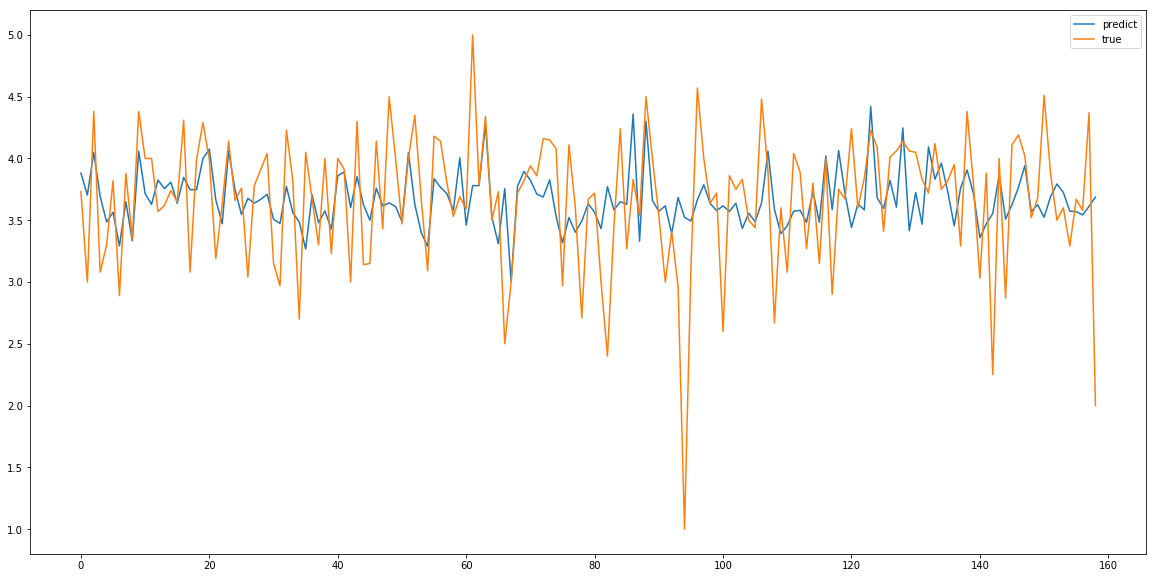

In [72]:
# test and plot the graph
predict_out = model.predict(x_test_norm)
predict_out = [rating_back(x) for x in predict_out]
compare_rating = pd.DataFrame([predict_out, [rating_back(x) for x in y_test_norm]], index=["predict","true"])
compare_rating = compare_rating.astype(float).T
compare_rating.plot(figsize=(20,10))

In [74]:
# A deviation of less than 0.5 is considered to be correct
acc_num = 0
sum_num = 0
for index, row in compare_rating.iterrows():
    sum_num += 1
    if( abs(row["predict"] - row["true"]) <= 0.5):
        acc_num += 1
print("Accuracy Rate: " + str(acc_num/sum_num))

Accuracy Rate: 0.7924528301886793


### 11. Find how to improve and give some advice
For the test data, I tried to fine-turn the values of each feature(increase or decrease), to find the highest possible rating score.

`Garden Party` is a book we read this summer, and it's not in my dataset. Therefore, I run the model on the `Garden Party` to test it. 


In [75]:
def predict(text: str):
    feature = Feature(text).get_feature()
    series = pd.Series(feature, name="test")
    x = (series.values - array_x.reshape(-1,23).min(axis=0)) / (array_x.reshape(-1,23).max(axis=0) - array_x.reshape(-1,23).min(axis=0))
    x = x.reshape(-1, 23, 1) 
    result = model.predict(x)
    return rating_back(result)

def find_improve_part(text: str):
    feature = Feature(text).get_feature()
    series = pd.Series(feature, name="test")
    x = (series.values - array_x.reshape(-1,23).min(axis=0)) / (array_x.reshape(-1,23).max(axis=0) - array_x.reshape(-1,23).min(axis=0))
    x = x.reshape(1, 23, 1) 
    result_origin = model.predict(x)
    max_rating = rating_back(result_origin)
    max_index = 0
    increase= 1
    for i in range(0,23):
        for rate in [0.1]:
            for if_increase in [1, -1]:
                try_series = series
                try_series.iloc[i] = try_series.iloc[i] * (1 + if_increase * rate)
                try_x = (try_series.values - array_x.reshape(-1,23).min(axis=0)) / (array_x.reshape(-1,23).max(axis=0) - array_x.reshape(-1,23).min(axis=0))
                try_x = try_x.reshape(1,23,1)
                try_result = model.predict(try_x)
                try_rating = rating_back(try_result)
                if try_rating > max_rating:
                    max_rating = try_rating
                    max_index = i
                    increase = if_increase
    return (max_index, if_increase, max_rating)

In [77]:
def predictNdValue(text):
    predict_rating = predict(text)
    max_index, if_increase, max_rating = find_improve_part(text)
    print("Your predict rating now is {:.2f}.\nYou might not do well in {}, you may {} it, then the rating can reach {:.2f}.".format(float(predict_rating[0]), item_dict[max_index], increase_dict[if_increase], float(max_rating[0])))

In [89]:
gardenParty = requests.get("https://github.com/JonathanReeve/course-computational-literary-analysis/blob/master/Texts/garden-party.md").text
predictNdValue(gardenParty)

Your predict rating now is 3.76.
You might not do well in stop_word_ratio, you may decline it, then the rating can reach 3.82.


### 12. PCA Analysis

Features we extracted can also help to clarify the category of the books. I use PCA to convert the parameter into 2 dimensions. And draw novels and poetries different in the graph. As we can see, they're distributed separately and bounded. We can also use this to predict a new book is poetry or novel before reading it.

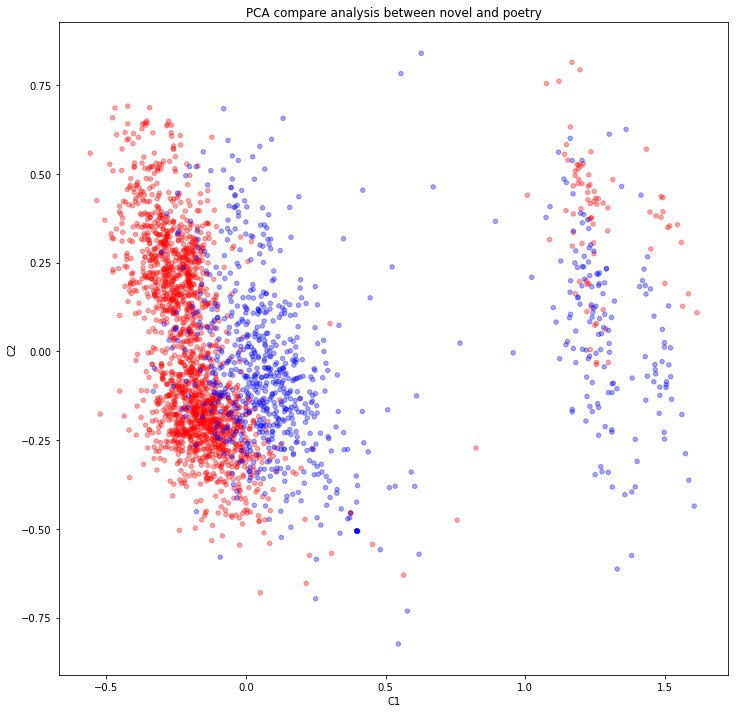

In [95]:
# 2D Chart
choice = [x for x in range(1,24)]
array_love = df_love.iloc[:,choice]
array_love = array_love.values
array_science = df_science.iloc[:,choice]
array_science = array_science.values
array_poetry = df_poetry.iloc[:,choice]
array_poetry = array_poetry.values
array_detective = df_detective.iloc[:,choice]
array_detective = array_detective.values
array = np.append(np.append(array_love.reshape(-1,len(choice)), array_science.reshape(-1,len(choice)),axis=0),
                  array_poetry.reshape(-1,len(choice)),axis=0)
array = (array - array.min(axis=0)) / (array.max(axis=0) - array.min(axis=0))
pca = PCA(n_components=2)

pcaOut = pca.fit_transform(array)
pcaDF = pd.DataFrame(pcaOut,columns=['C1','C2'])
ax = pcaDF.plot.scatter(x="C1", y="C2", figsize=(12,12), 
                        c=list("r"*len(array_love)+"r"*len(array_science)+"b"*len(array_poetry)),alpha=0.35, 
                        title="PCA compare analysis between novel and poetry")

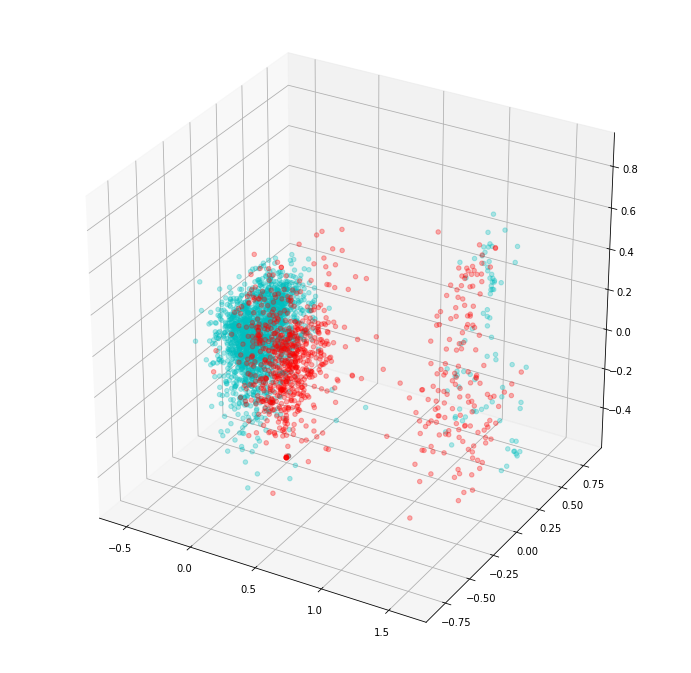

In [97]:
# 3D Chart
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
choice = [x for x in range(1,24)]
array_love = df_love.iloc[:,choice]
array_love = array_love.values
array_science = df_science.iloc[:,choice]
array_science = array_science.values
array_poetry = df_poetry.iloc[:,choice]
array_poetry = array_poetry.values
array = np.append(np.append(array_love.reshape(-1,len(choice)), array_science.reshape(-1,len(choice)),axis=0),array_poetry.reshape(-1,len(choice)),axis=0)

array = (array - array.min(axis=0)) / (array.max(axis=0) - array.min(axis=0))
pca = PCA(n_components=3)

pcaOut = pca.fit_transform(array)
pcaDF = pd.DataFrame(pcaOut,columns=['C1','C2',"C3"])
fig = plt.figure(figsize=(12,12))

ax = fig.add_subplot(111, projection="3d")
ax.scatter(pcaDF['C1'], pcaDF['C2'], pcaDF['C3'],c=list("c"*len(array_love)+"c"*len(array_science)+"r"*len(array_poetry)), alpha=0.3)


## IV. Conclusion

In this project, we find that the features of a book's writing style affect its rating score. We build a model to predict the rating score, and we trained the model on a certain size data set. We also use the model to provide suggestions for authors to improve their works. The writing style features can also help us to classified books into different categories. This may be helpful to book classification.

## V. Future Direction
+ Scale of data sets can significantly affect the accuracy of the model, so increasing the scale and categories of data sets can improve the accuracy of the model.
+ The prediction model used at present is simple, but overfit also may happen. We can select other models in subsequent work.
+ The features are extracted manually at present.
    + We can try to extract more features.
    + Try on extracting features automated.

## VI. Reference
\[1\] CMU. *The CMU Pronouncing Dictionary.*

\[2\] Vivian Cook. List of English Structure (Function) Words. [http://www.viviancook.uk/Words/StructureWordsList](http://www.viviancook.uk/Words/StructureWordsList.htm).

\[3\] Hassaan Elahi, & Haris Muneer. (2018, July 3). *Identifying Different Writing Styles in a Document Intrinsically using Stylometric Analysis.* Zenodo.

\[4\] Flesch, Rudolf. *How to Write Plain English*. University of Canterbury. Archived from the original on July 12, 2016. Retrieved 12 July 2016.

\[5\] Kincaid JP, Fishburne RP Jr, Rogers RL, Chissom BS (February 1975). *Derivation of new readability formulas (Automated Readability Index, Fog Count and Flesch Reading Ease Formula) for Navy enlisted personnel*

\[6\] Chall, Jeanne Sternlicht; Dale, Edgar (May 1, 1995). Readability revisited. ISBN 1571290087.

\[7\] Miranda-García, A. & Calle-MartÍn, J. Lang Resources & Evaluation (2005) 39: 287.

In [101]:
# Run with: python wordcount.py my-file.ipynb
import sys
import json

wordCount = 0
filename = "Test-Feature-Analyse.ipynb"
with open(filename, encoding='utf-8') as f:
    notebookRaw = f.read()
    notebookParsed = json.loads(notebookRaw)
    for cell in notebookParsed['cells']:
        if cell['cell_type'] == "markdown":
            contents = ''.join(cell['source'])
            words = contents.replace('#','').strip().split(' ')
            wordCount += len(words)
print(filename + ": {} words".format(wordCount))

Test-Feature-Analyse.ipynb: 1595 words
